# Imports

In [12]:
import random
import os
import time
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import plotly.express as px
        
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Flatten, Dense, BatchNormalization, Activation,Dropout

from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model

In [13]:
!nvidia-smi

Sat Jul  9 06:37:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
TRAINING_DIR = '../input/clothing-dataset-full/images_compressed'
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCHS = 100
LEARNING_RATE = 0.001

In [15]:
print(f"There are {len(os.listdir(TRAINING_DIR))} images in training set")

There are 5762 images in training set


# Data Preprocessing

In [16]:
file_names = os.listdir(TRAINING_DIR)
file_names[:10]

['d619091d-fc8d-4730-9f3c-2a042e876272.jpg',
 'b0d71fba-23a7-4912-b6c6-16b7d8a5bd43.jpg',
 '7f17b410-d375-409e-b5b3-010122df5748.jpg',
 'a1935717-7c7e-448c-9359-9c958ebbd2eb.jpg',
 '638f066a-218c-4850-9771-4883a908d6a3.jpg',
 '0c024616-1289-4747-91da-71a4aedd4ced.jpg',
 'bf583ce5-a849-44b8-afe9-59ab221d9d27.jpg',
 'ebb27e08-5ec0-4107-b857-170dd8861cb8.jpg',
 '51bdf9e1-6ff4-46fe-9051-2821fff88f85.jpg',
 '186eb9e1-79fa-4aba-97c8-f2da0e6a2413.jpg']

In [17]:
data = pd.read_csv('../input/clothing-dataset-full/images.csv')

In [18]:
data.head()

image  sender_id     label   kids
0  4285fab0-751a-4b74-8e9b-43af05deee22        124  Not sure  False
1  ea7b6656-3f84-4eb3-9099-23e623fc1018        148   T-Shirt  False
2  00627a3f-0477-401c-95eb-92642cbe078d         94  Not sure  False
3  ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa         43   T-Shirt  False
4  3b86d877-2b9e-4c8b-a6a2-1d87513309d0        189     Shoes  False

In [19]:
data['image'] = data['image']+'.jpg'
data_1 = data[['image', 'label']]

In [20]:
data_1.head()

image     label
0  4285fab0-751a-4b74-8e9b-43af05deee22.jpg  Not sure
1  ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg   T-Shirt
2  00627a3f-0477-401c-95eb-92642cbe078d.jpg  Not sure
3  ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg   T-Shirt
4  3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg     Shoes

In [21]:
data_1['image']

0       4285fab0-751a-4b74-8e9b-43af05deee22.jpg
1       ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg
2       00627a3f-0477-401c-95eb-92642cbe078d.jpg
3       ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg
4       3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg
                          ...                   
5398    dfd4079d-967b-4b3e-8574-fbac11b58103.jpg
5399    befa14be-8140-4faf-8061-1039947e329d.jpg
5400    5379356a-40ee-4890-b416-2336a7d84061.jpg
5401    65507fb8-3456-4c15-b53e-d1b03bf71a59.jpg
5402    32b99302-cec7-4dec-adfa-3d4029674209.jpg
Name: image, Length: 5403, dtype: object

Remove corrupted images from the data set

In [22]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(TRAINING_DIR).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

../input/clothing-dataset-full/images_compressed/b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg
../input/clothing-dataset-full/images_compressed/1d0129a1-f29a-4a3f-b103-f651176183eb.jpg
../input/clothing-dataset-full/images_compressed/c60e486d-10ed-4f64-abab-5bb698c736dd.jpg
../input/clothing-dataset-full/images_compressed/d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg
../input/clothing-dataset-full/images_compressed/040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg
../input/clothing-dataset-full/images_compressed/784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg


In [23]:
corrupted = ['b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg', '1d0129a1-f29a-4a3f-b103-f651176183eb.jpg', 'c60e486d-10ed-4f64-abab-5bb698c736dd.jpg', 
            'd028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg', '040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg', '784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg']

In [24]:
data_1 = data_1.drop(data_1[data_1['image'].isin(corrupted)].index, axis=0)

# Data Visualization

In [26]:
fig = px.bar(data_1['label'].value_counts())
fig.show()

In [27]:
class_names = list(data_1['label'].unique())
print(len(class_names))
class_names

20


['Not sure',
 'T-Shirt',
 'Shoes',
 'Shorts',
 'Shirt',
 'Pants',
 'Skirt',
 'Other',
 'Top',
 'Outwear',
 'Dress',
 'Body',
 'Longsleeve',
 'Undershirt',
 'Hat',
 'Polo',
 'Blouse',
 'Hoodie',
 'Skip',
 'Blazer']

In [28]:
class_dict = dict(zip(class_names, range(len(class_names))))

In [29]:
class_dict

{'Not sure': 0,
 'T-Shirt': 1,
 'Shoes': 2,
 'Shorts': 3,
 'Shirt': 4,
 'Pants': 5,
 'Skirt': 6,
 'Other': 7,
 'Top': 8,
 'Outwear': 9,
 'Dress': 10,
 'Body': 11,
 'Longsleeve': 12,
 'Undershirt': 13,
 'Hat': 14,
 'Polo': 15,
 'Blouse': 16,
 'Hoodie': 17,
 'Skip': 18,
 'Blazer': 19}

In [30]:
labels_to_remove = ['Skip', 'Not sure', 'Other', 'Blouse']

In [31]:
data_1 = data_1[~data_1['label'].isin(labels_to_remove)]

In [32]:
fig = px.bar(data_1['label'].value_counts())
fig.show()

In [33]:
y_train = data_1['label']

In [34]:
def show_random_training_image():
    random_index = random.choice(data_1.index)
    img_path = data_1['image'][random_index]
    label = data_1['label'][random_index]
    complete_path = TRAINING_DIR + '/' + img_path
    image = mpimg.imread(complete_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)

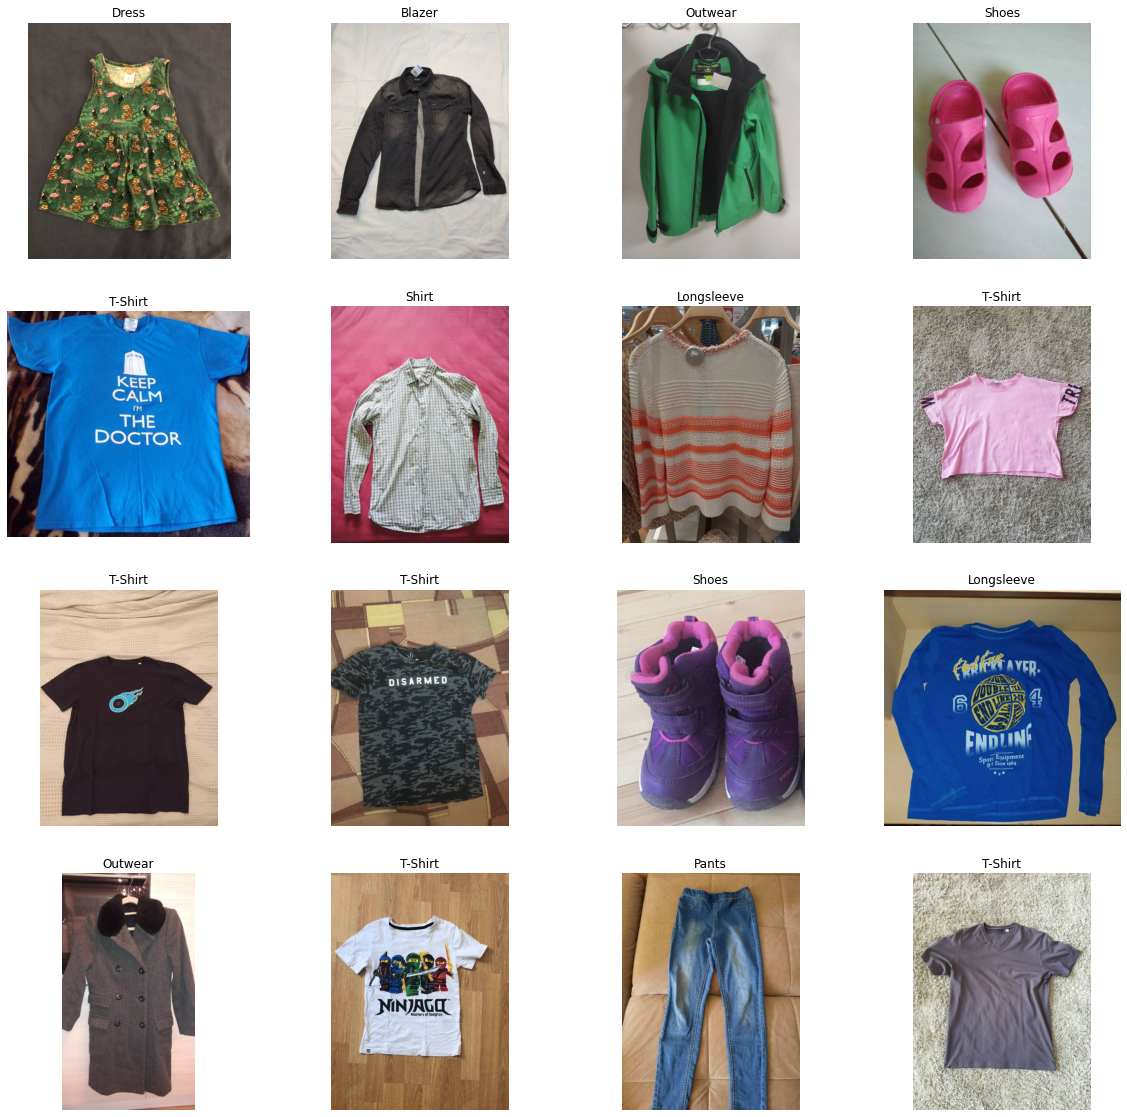

In [35]:
plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    show_random_training_image()

In [36]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.3,
                                  height_shift_range=0.3,
                                  zoom_range=0.3,
                                  horizontal_flip=True,
                                  validation_split=0.1)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_1,
    directory=TRAINING_DIR,
    x_col='image',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=data_1,
    directory=TRAINING_DIR,
    x_col='image',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation'
)

Found 4566 validated image filenames belonging to 16 classes.
Found 507 validated image filenames belonging to 16 classes.


In [37]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

pre_trained_model = MobileNetV2(input_shape=(224, 224, 3),
                                include_top=False,
                                weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = True

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('out_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

2022-07-09 06:37:44.144472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 06:37:44.148533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 06:37:44.149457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 06:37:44.151279: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step
last layer output shape:  (None, 7, 7, 1280)


In [38]:
x = Flatten()(last_output)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.3)(x)
x = Dense(16, activation='softmax')(x)           

model = Model(pre_trained_model.input, x)

In [40]:
learn_rate = LEARNING_RATE

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
cb = ModelCheckpoint('mobilenetv2.h5', save_best_only=True)
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.1, patience=5, min_lr=1e-5)

adam = adam_v2.Adam(learning_rate=learn_rate)
model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])


history = model.fit(train_generator, epochs=EPOCHS,
                    validation_data=validation_generator, 
                    callbacks=[es, cb, lrr])

model = tf.keras.models.load_model('mobilenetv2.h5')

2022-07-09 06:37:48.910700: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-07-09 06:37:56.523701: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


143/143 [==============================] - 95s 568ms/step - loss: 6.7307 - accuracy: 0.3730 - val_loss: 20.7457 - val_accuracy: 0.0986
Epoch 2/100
143/143 [==============================] - 81s 565ms/step - loss: 3.7747 - accuracy: 0.4304 - val_loss: 6.0734 - val_accuracy: 0.1341
Epoch 3/100
143/143 [==============================] - 80s 560ms/step - loss: 3.0621 - accuracy: 0.4704 - val_loss: 7.9047 - val_accuracy: 0.0237
Epoch 4/100
143/143 [==============================] - 81s 566ms/step - loss: 2.8614 - accuracy: 0.5313 - val_loss: 22.6773 - val_accuracy: 0.1262
Epoch 5/100
143/143 [==============================] - 80s 559ms/step - loss: 2.1780 - accuracy: 0.6027 - val_loss: 8.9170 - val_accuracy: 0.1183
Epoch 6/100
143/143 [==============================] - 80s 557ms/step - loss: 1.8016 - accuracy: 0.6327 - val_loss: 5.0854 - val_accuracy: 0.2821
Epoch 7/100
143/143 [==============================] - 79s 555ms/step - loss: 1.8574 - accuracy: 0.6531 - val_loss: 24.3480 - val_accu

# Visualize Model Predictions

In [41]:
loss, accuracy = model.evaluate(validation_generator, verbose=0)

In [42]:
print(f"Model Loss is {loss:.2f} and Accuracy is {100*np.round(accuracy, 4)}%")

Model Loss is 0.73 and Accuracy is 79.09%


In [43]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

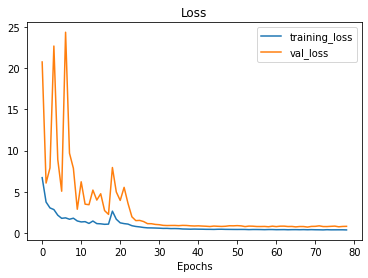

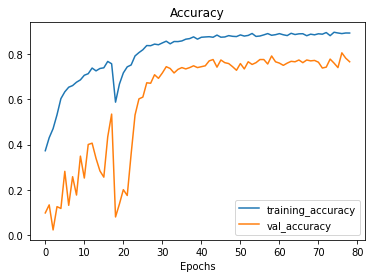

In [44]:
plot_loss_curves(history)

# Prediction on validation Images

In [45]:
classes = list(train_generator.class_indices.keys())

In [46]:
def predict_val_image(index):
    predictions =  model.predict(val_images, verbose=0)[index]
    true_label = classes[val_labels[index].argmax()]
    predicted_label = classes[predictions.argmax()] 

    if(true_label== predicted_label):
        color = 'green'  
    else:
        color = 'red'

    plt.title(f"True : {true_label} Predicted: {predicted_label}", color=color)
    plt.imshow(val_images[index])
    plt.axis('off')

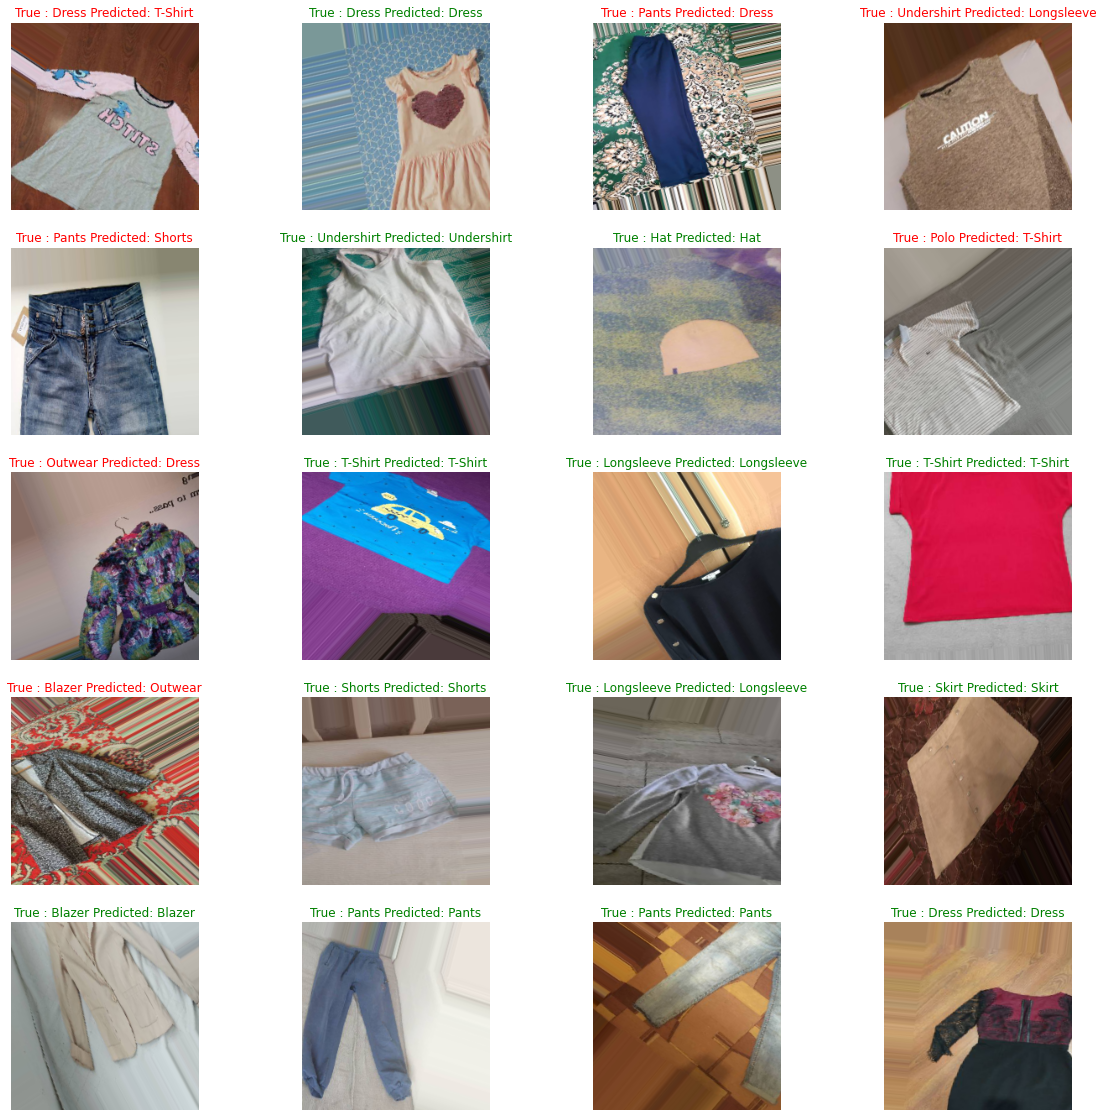

In [55]:
val_images, val_labels = validation_generator.next()
plt.figure(figsize=(20, 20))
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    predict_val_image(i)

# Predictions on Unseen Images

In [48]:
custom_dir = '../input/clothing-dataset-full/images_original'

In [49]:
custom_paths = []
for image in os.listdir(custom_dir):
        custom_paths.append(custom_dir+'/'+image)

In [50]:
def predict_random_image():
    path = random.choice(custom_paths)
    image = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    input_arr = input_arr.astype('float32') / 255.
    predictions = model.predict(input_arr, verbose=0)
    series = pd.Series(predictions[0], index=classes)
    predicted_classes = np.argsort(predictions)
    predictions.sort()
    plt.title(f"{classes[predicted_classes[0][-1]]} - {round(predictions[0][-1] * 100,2)}% \n{classes[predicted_classes[0][-2]]} - {round(predictions[0][-2] * 100,2)}% \n{classes[predicted_classes[0][-3]]} - {round(predictions[0][-2] * 100,3)}%")
    plt.imshow(image)
    plt.axis('off')

## Top 3 predictions for unseen High-res Images

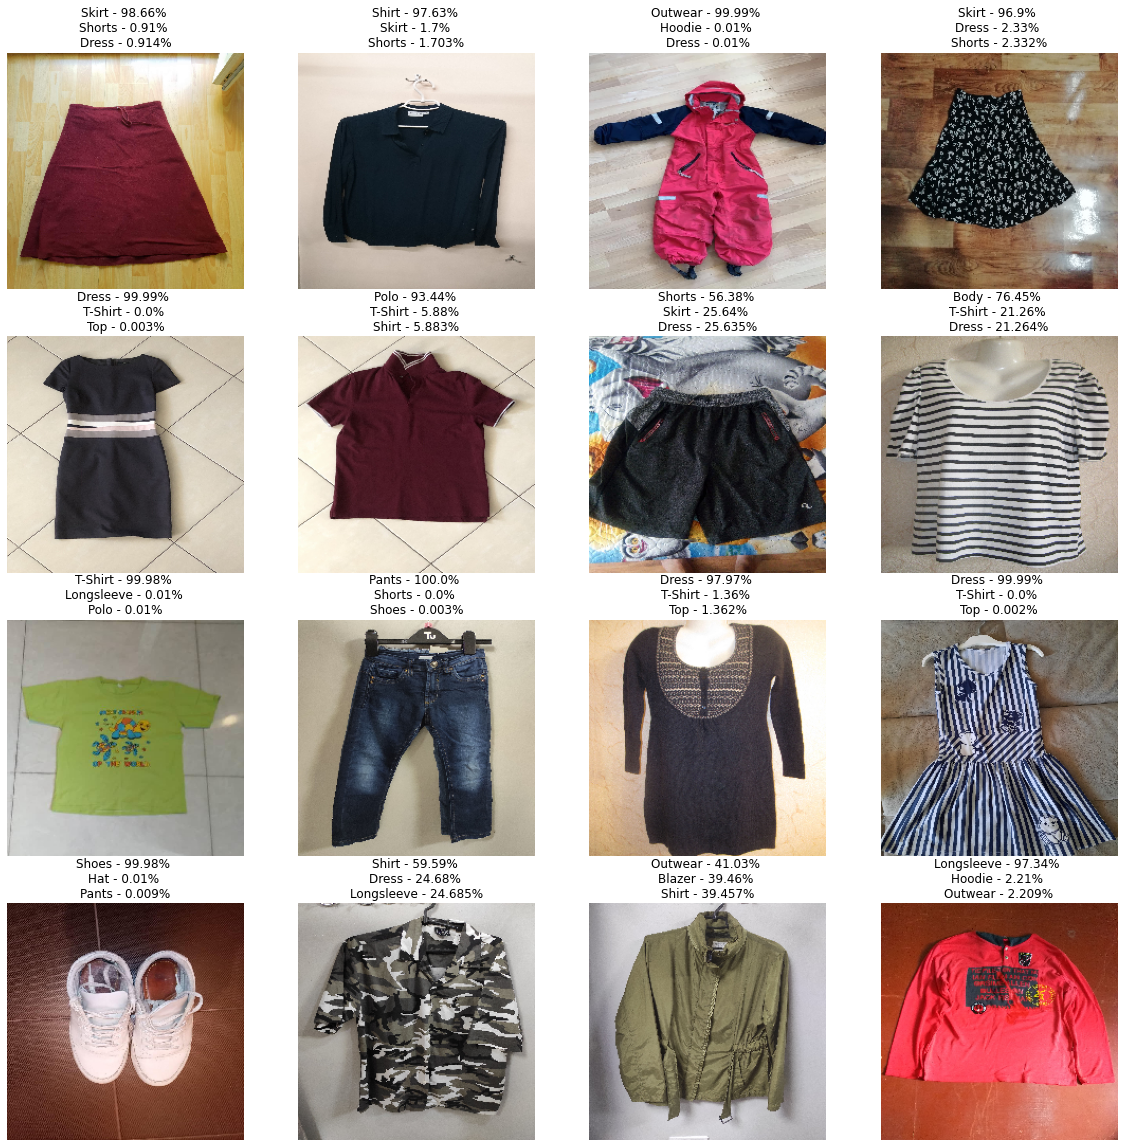

In [51]:
plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    predict_random_image()